In [ ]:
import nltk
from nltk.corpus import inaugural

nltk.download("inaugural")

In [2]:
for idx, file_id in enumerate(inaugural.fileids()):
    print(f"#{idx+1} {file_id}")

#1 1789-Washington.txt
#2 1793-Washington.txt
#3 1797-Adams.txt
#4 1801-Jefferson.txt
#5 1805-Jefferson.txt
#6 1809-Madison.txt
#7 1813-Madison.txt
#8 1817-Monroe.txt
#9 1821-Monroe.txt
#10 1825-Adams.txt
#11 1829-Jackson.txt
#12 1833-Jackson.txt
#13 1837-VanBuren.txt
#14 1841-Harrison.txt
#15 1845-Polk.txt
#16 1849-Taylor.txt
#17 1853-Pierce.txt
#18 1857-Buchanan.txt
#19 1861-Lincoln.txt
#20 1865-Lincoln.txt
#21 1869-Grant.txt
#22 1873-Grant.txt
#23 1877-Hayes.txt
#24 1881-Garfield.txt
#25 1885-Cleveland.txt
#26 1889-Harrison.txt
#27 1893-Cleveland.txt
#28 1897-McKinley.txt
#29 1901-McKinley.txt
#30 1905-Roosevelt.txt
#31 1909-Taft.txt
#32 1913-Wilson.txt
#33 1917-Wilson.txt
#34 1921-Harding.txt
#35 1925-Coolidge.txt
#36 1929-Hoover.txt
#37 1933-Roosevelt.txt
#38 1937-Roosevelt.txt
#39 1941-Roosevelt.txt
#40 1945-Roosevelt.txt
#41 1949-Truman.txt
#42 1953-Eisenhower.txt
#43 1957-Eisenhower.txt
#44 1961-Kennedy.txt
#45 1965-Johnson.txt
#46 1969-Nixon.txt
#47 1973-Nixon.txt
#48 1977-Car

In [3]:
presidents = set([file_id[5:-4] for file_id in inaugural.fileids()])
president_data_dict = {}

for index, president in enumerate(presidents):
    speeches = [
        inaugural.sents(file_id)
        for file_id in inaugural.fileids()
        if president in file_id
    ]
    sent_num = len([sent for speech in speeches for sent in speech])
    president_data_dict[president] = sent_num

sentences_by_president_name: dict[str, int] = dict(
    sorted(president_data_dict.items(), key=lambda pd: pd[1], reverse=True)
)

for idx, president_item in enumerate(sentences_by_president_name.items()):
    print(f"{idx + 1}: {president_item[0]} - {president_item[1]} sentences")

1: Harrison - 367 sentences
2: Bush - 337 sentences
3: Roosevelt - 308 sentences
4: Reagan - 253 sentences
5: Monroe - 251 sentences
6: McKinley - 230 sentences
7: Eisenhower - 215 sentences
8: Obama - 204 sentences
9: Coolidge - 197 sentences
10: Clinton - 193 sentences
11: Nixon - 175 sentences
12: Biden - 170 sentences
13: Lincoln - 165 sentences
14: Taft - 159 sentences
15: Hoover - 158 sentences
16: Polk - 153 sentences
17: Harding - 149 sentences
18: Wilson - 128 sentences
19: Truman - 116 sentences
20: Garfield - 112 sentences
21: Adams - 111 sentences
22: Pierce - 104 sentences
23: Cleveland - 102 sentences
24: VanBuren - 95 sentences
25: Johnson - 94 sentences
26: Trump - 90 sentences
27: Buchanan - 89 sentences
28: Jefferson - 87 sentences
29: Grant - 85 sentences
30: Hayes - 59 sentences
31: Jackson - 55 sentences
32: Madison - 54 sentences
33: Carter - 53 sentences
34: Kennedy - 52 sentences
35: Washington - 28 sentences
36: Taylor - 22 sentences


In [4]:
PRESIDENT_A = "Biden"
PRESIDENT_B = "Obama"

In [5]:
speeches_a = [
    inaugural.sents(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_A in file_id
]

sents_a = [sent for speech in speeches_a for sent in speech]
for sentence in sents_a[:50]:
    print(" ".join(sentence))

print(f"...\n\nSpeaker: President {PRESIDENT_A}, {len(sents_a)} sentences")

Chief Justice Roberts , Vice President Harris , Speaker Pelosi , Leader Schumer , Leader McConnell , Vice President Pence , and my distinguished guests , and my fellow Americans : This is America ' s day .
This is democracy ' s day , a day of history and hope , of renewal and resolve .
Through a crucible for the ages America has been tested anew , and America has risen to the challenge .
Today we celebrate the triumph not of a candidate , but of a cause , the cause of democracy .
The peopleâ  the will of the people has been heard , and the will of the people has been heeded .
We ' ve learned again that democracy is precious , democracy is fragile .
And at this hour , my friends , democracy has prevailed .
So now , on this hallowed ground where just a few days ago violence sought to shake the Capitol ' s very foundation , we come together as one Nation under God , indivisible , to carry out the peaceful transfer of power as we have for more than two centuries .
As we look ahead in our

In [6]:
speeches_b = [
    inaugural.sents(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_B in file_id
]

sents_b = [sent for speech in speeches_b for sent in speech]
for sentence in sents_b[:50]:
    print(" ".join(sentence))
print(f"...\n\nSpeaker: President {PRESIDENT_B}, {len(sents_b)} sentences")

My fellow citizens :
I stand here today humbled by the task before us , grateful for the trust you have bestowed , mindful of the sacrifices borne by our ancestors .
I thank President Bush for his service to our nation , as well as the generosity and cooperation he has shown throughout this transition .
Forty - four Americans have now taken the presidential oath .
The words have been spoken during rising tides of prosperity and the still waters of peace .
Yet , every so often the oath is taken amidst gathering clouds and raging storms .
At these moments , America has carried on not simply because of the skill or vision of those in high office , but because We the People have remained faithful to the ideals of our forbearers , and true to our founding documents .
So it has been .
So it must be with this generation of Americans .
That we are in the midst of crisis is now well understood .
Our nation is at war , against a far - reaching network of violence and hatred .
Our economy is badl

In [7]:
from authorship_tool.main.util import frequency_calculator as fc

existing_tags: set[str] = set()

for sentence in sents_a + sents_b:
    existing_tags.update(fc.all_pos_frequency(sentence).keys())

print(existing_tags)

{'VBZ', 'RBS', 'NNPS', 'JJR', 'UH', 'CD', 'RB', 'WDT', 'VBG', 'TO', 'DT', 'RBR', ':', 'JJS', 'VBD', 'PDT', 'POS', 'RP', 'JJ', 'NN', 'WRB', 'VBP', 'MD', 'PRP', 'VBN', 'EX', 'IN', ',', 'WP', 'VB', 'WP$', "''", 'PRP$', '.', 'NNP', 'CC', 'NNS'}


In [ ]:
from authorship_tool.main.util.dataset_generator import DatasetGenerator
import pandas as pd
import numpy as np

dg = DatasetGenerator(existing_tags)
data = []
correctness = []

for sentence in sents_a:
    x, y = dg.generate_dataset_sent(sentence, existing_tags, True)
    data.append(x)
    correctness.append(y)

for sentence in sents_b:
    x, y = dg.generate_dataset_sent(sentence, existing_tags, False)
    data.append(x)
    correctness.append(y)

In [35]:
df = pd.DataFrame(data, columns=dg.columns)
nd_correctness = np.array(correctness)

display(df.head(10))

,word variation,uncommon word frequency,sentence length,average word length,VBZ,RBS,NNPS,JJR,UH,CD,...,",",WP,VB,WP$,'',PRP$,.,NNP,CC,NNS
0,0.710526,0.842105,38,4.421053,0.026316,0.0,0.026316,0.000000,0.0,0.000000,...,0.184211,0.0,0.000000,0.0,0.000000,0.052632,0.026316,0.026316,0.052632,0.026316
1,0.789474,0.631579,19,3.263158,0.052632,0.0,0.000000,0.000000,0.0,0.000000,...,0.105263,0.0,0.000000,0.0,0.052632,0.000000,0.052632,0.000000,0.105263,0.000000
2,0.850000,0.550000,20,4.200000,0.100000,0.0,0.000000,0.000000,0.0,0.000000,...,0.050000,0.0,0.000000,0.0,0.000000,0.000000,0.050000,0.100000,0.050000,0.050000
3,0.700000,0.500000,20,3.700000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.100000,0.0,0.000000,0.0,0.000000,0.000000,0.050000,0.000000,0.050000,0.000000
4,0.636364,0.409091,22,3.545455,0.090909,0.0,0.000000,0.000000,0.0,0.000000,...,0.045455,0.0,0.000000,0.0,0.000000,0.000000,0.045455,0.000000,0.045455,0.090909
5,0.857143,0.642857,14,4.285714,0.142857,0.0,0.000000,0.000000,0.0,0.000000,...,0.071429,0.0,0.000000,0.0,0.071429,0.000000,0.071429,0.000000,0.000000,0.071429
6,0.916667,0.666667,12,3.833333,0.083333,0.0,0.000000,0.000000,0.0,0.000000,...,0.166667,0.0,0.000000,0.0,0.000000,0.083333,0.083333,0.000000,0.083333,0.083333
7,0.865385,0.538462,52,4.000000,0.000000,0.0,0.000000,0.019231,0.0,0.019231,...,0.076923,0.0,0.019231,0.0,0.000000,0.000000,0.019231,0.019231,0.000000,0.019231
8,0.804348,0.565217,46,3.847826,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.065217,0.0,0.043478,0.0,0.000000,0.021739,0.021739,0.021739,0.043478,0.021739
9,1.000000,0.500000,10,3.300000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000


In [9]:
print(df.dtypes)

word variation             float64
uncommon word frequency    float64
sentence length              int64
average word length        float64
VBZ                        float64
RBS                        float64
NNPS                       float64
JJR                        float64
UH                         float64
CD                         float64
RB                         float64
WDT                        float64
VBG                        float64
TO                         float64
DT                         float64
RBR                        float64
:                          float64
JJS                        float64
VBD                        float64
PDT                        float64
POS                        float64
RP                         float64
JJ                         float64
NN                         float64
WRB                        float64
VBP                        float64
MD                         float64
PRP                        float64
VBN                 

In [10]:
print(df.isna().sum())

word variation             0
uncommon word frequency    0
sentence length            0
average word length        0
VBZ                        0
RBS                        0
NNPS                       0
JJR                        0
UH                         0
CD                         0
RB                         0
WDT                        0
VBG                        0
TO                         0
DT                         0
RBR                        0
:                          0
JJS                        0
VBD                        0
PDT                        0
POS                        0
RP                         0
JJ                         0
NN                         0
WRB                        0
VBP                        0
MD                         0
PRP                        0
VBN                        0
EX                         0
IN                         0
,                          0
WP                         0
VB                         0
WP$           

In [11]:
import sklearn
import lightgbm as lgb


DESIRED_SCORE = 0.9

def learn(df: pd.DataFrame, nd_correctness: np.ndarray) -> tuple[lgb.LGBMClassifier, pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray, np.ndarray, np.ndarray, float]:
    train_data, test_data, train_ans, test_ans = sklearn.model_selection.train_test_split(
        df, nd_correctness
    )

    model = lgb.LGBMClassifier()
    model.fit(train_data.values, train_ans)

    ans_pred_prob = model.predict_proba(test_data)[:, 1]
    ans_pred = model.predict(test_data)

    val = sklearn.metrics.roc_auc_score(test_ans, ans_pred_prob)
    return model, train_data, test_data, train_ans, test_ans, ans_pred_prob, ans_pred, val


val = 0
while val < DESIRED_SCORE:
    model, train_data, test_data, train_ans, test_ans, ans_pred_prob, ans_pred, val = learn(
        df, nd_correctness
    )

[LightGBM] [Info] Number of positive: 132, number of negative: 148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471429 -> initscore=-0.114410
[LightGBM] [Info] Start training from score -0.114410
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [12]:
print(f"auc-rocスコア: {val}")

auc-rocスコア: 0.8129699248120301


In [19]:
import pickle
from os import makedirs, path, getcwd

dump_dir = path.join(getcwd(), "dump", "inaugural")
makedirs(dump_dir, exist_ok=True)

In [24]:
import pickle

with open(path.join(dump_dir, "lgbm_model.pkl"), "wb") as f:
  pickle.dump(model, f)


In [25]:
data_dir = path.join(dump_dir, "data")
makedirs(data_dir, exist_ok=True)

In [28]:

train_data.to_csv(path.join(data_dir, "train_data.csv"), index=False)
test_data.to_csv(path.join( data_dir, "test_data.csv"), index=False)
pd.DataFrame(train_ans).to_csv(path.join( data_dir, "train_ans.csv"), index=False)
pd.DataFrame(test_ans).to_csv(path.join( data_dir, "test_ans.csv"), index=False)
pd.DataFrame(ans_pred_prob).to_csv(path.join( data_dir, "and_pred_prob.csv"), index=False)
pd.DataFrame(ans_pred).to_csv(path.join( data_dir, "ans_pred.csv"), index=False)

In [29]:
display(pd.crosstab(test_ans, ans_pred))

col_0,False,True
row_0,,
False,44,12
True,12,26


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


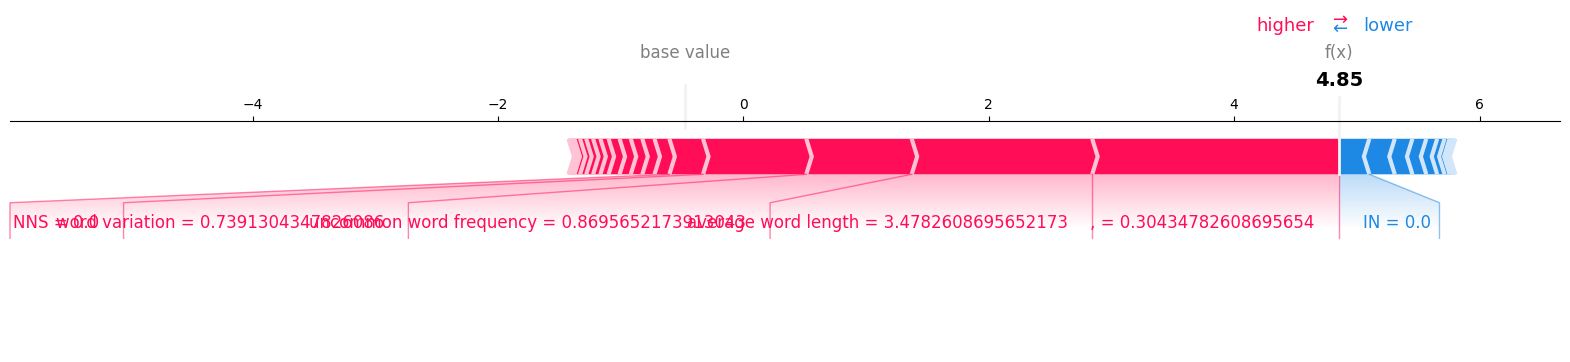

In [30]:
import shap

exp = shap.TreeExplainer(model)
sv_test = exp.shap_values(test_data)[1]

# shap.initjs()
shap.force_plot(exp.expected_value[1], sv_test[0], test_data.iloc[0], matplotlib=True)

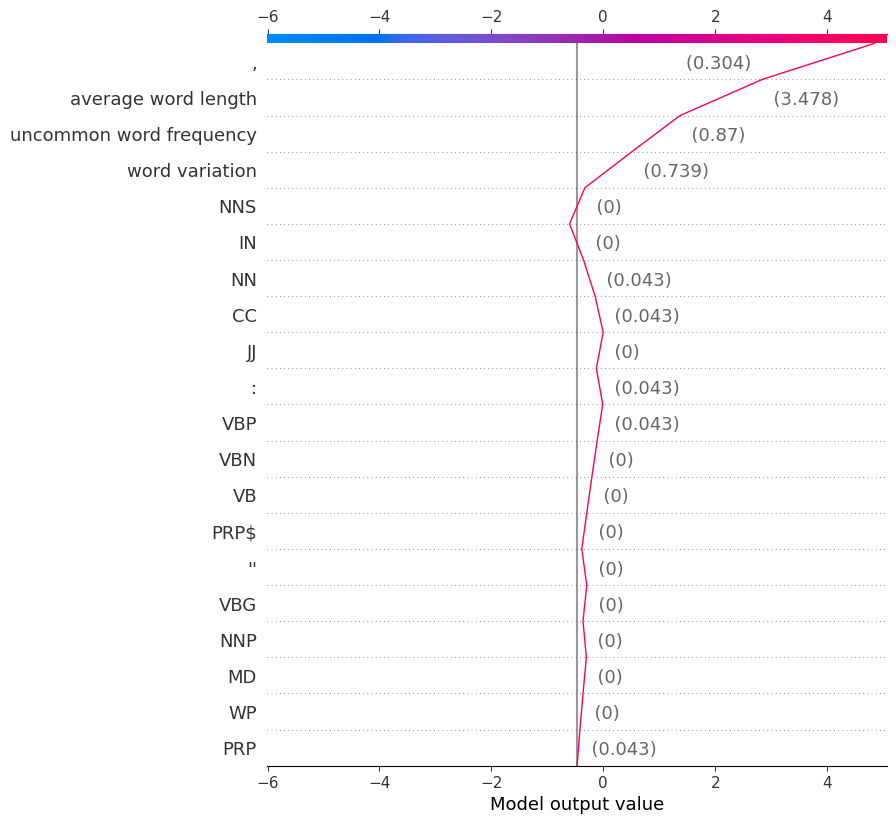

In [31]:
shap.decision_plot(exp.expected_value[1], sv_test[0], test_data.iloc[0])

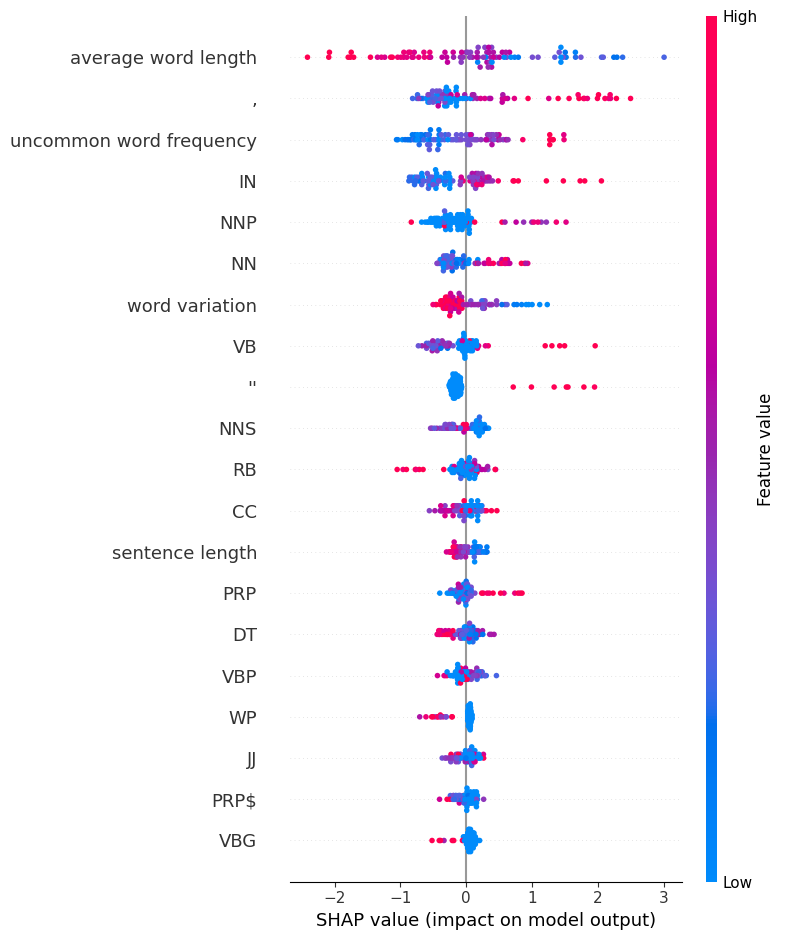

In [32]:
shap.summary_plot(sv_test, test_data)

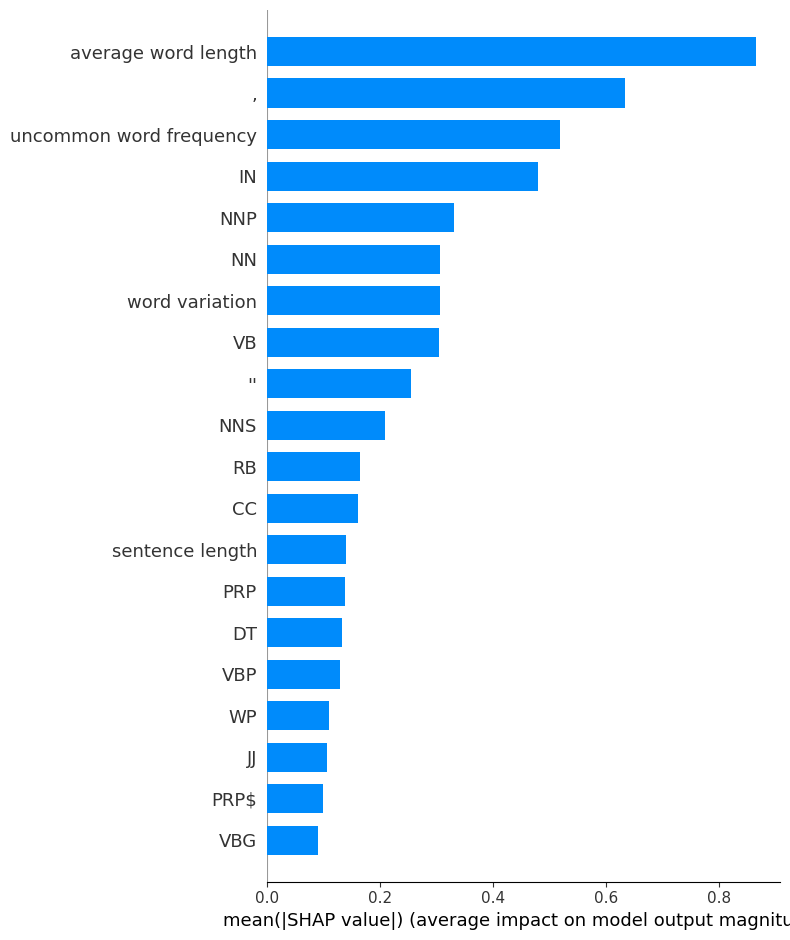

In [33]:
shap.summary_plot(sv_test, test_data, plot_type="bar")